In [13]:
import pandas as pd
import sklearn
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import lance
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [14]:
SaaS_data = pd.read_csv("SaaS-Sales.csv")
SaaS_data.head(10000)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,EMEA-2020-110422,1/22/2020,20200122,Dan Allan,Germany,Hamburg,EMEA,EU-WEST,Johnson & Johnson,1055,Healthcare,SMB,SaaS Connector Pack,ETHXMB5TMD,25.2480,3,0.20,4.1028
9990,9991,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,1005,Finance,SMB,SaaS Connector Pack,LYHOKTRY7L,91.9600,2,0.00,15.6332
9991,9992,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,1005,Finance,SMB,Site Analytics,I5SVMI6M88,258.5760,2,0.20,19.3932
9992,9993,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,1005,Finance,SMB,Support,JHLW4P6LQ2,29.6000,4,0.00,13.3200


In [15]:
q1 = SaaS_data['Sales'].quantile(0.25)
q3 = SaaS_data['Sales'].quantile(0.75)
iqr = q3 - q1
out_low = q1 - 1.5 * iqr
out_high = q3 + 1.5 * iqr

In [16]:
np.sum(SaaS_data.loc[:, 'Sales'] < out_low)
np.sum(SaaS_data.loc[:, 'Sales'] > out_high)
SaaS_data['outliers_tukey'] = (SaaS_data.loc[:, 'Sales'] < out_low) | (SaaS_data.loc[:, 'Sales'] > out_high)
SaaS_data[SaaS_data['outliers_tukey'] == True]

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit,outliers_tukey
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820,True
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310,True
7,8,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,1065,Finance,SMB,Site Analytics,07842ES7DY,907.1520,6,0.20,90.7152,True
10,11,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,1065,Finance,SMB,ContactMatcher,43NZ37VE2D,1706.1840,9,0.20,85.3092,True
11,12,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,1065,Finance,SMB,Site Analytics,JG14MOU94R,911.4240,4,0.20,68.3568,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9931,9932,AMER-2021-104948,11/13/2021,20211113,Kimberly Newman,United States,Anaheim,AMER,NAMER,Amazon,1004,Tech,SMB,Marketing Suite,3D56KMLTYI,683.3320,4,0.15,-40.1960,True
9942,9943,AMER-2020-143371,12/28/2020,20201228,Carol Forsyth,United States,San Francisco,AMER,NAMER,Nestle,1089,Consumer Products,SMB,Marketing Suite - Gold,UPQPITMHDF,998.8200,9,0.00,29.9646,True
9947,9948,APJ-2023-121559,6/2/2023,20230602,Harry McGrath,India,Delhi,APJ,IND,Valero Energy,1093,Energy,Strategic,FinanceHub,ZTX5WHU4ZQ,1925.8800,6,0.00,539.2464,True
9948,9949,APJ-2023-121559,6/2/2023,20230602,Harry McGrath,India,Delhi,APJ,IND,Valero Energy,1093,Energy,Strategic,OneView,ZGTMROAYTX,2405.2000,8,0.00,793.7160,True


In [17]:
SaaS_data.sample(25)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit,outliers_tukey
7383,7384,AMER-2022-105732,9/14/2022,20220914,Carol Campbell,Costa Rica,San José,AMER,LATAM,Home Depot,1047,Retail,SMB,Support,KQJ9E4GNES,17.610,3,0.0,8.4528,False
5464,5465,AMER-2020-146591,1/20/2020,20200120,Sonia Parsons,Chile,Puente Alto,AMER,LATAM,Pemex,1058,Energy,SMB,SaaS Connector Pack - Gold,0WV94HERYR,108.720,5,0.2,36.6930,False
2307,2308,EMEA-2023-116225,11/6/2023,20231106,Tracey Skinner,United Kingdom,London,EMEA,UKIR,Comcast,1022,Communications,SMB,Data Smasher,XZNKCRRPWL,390.750,5,0.0,171.9300,False
7433,7434,AMER-2020-161249,8/9/2020,20200809,Heather Dyer,Chile,Santiago,AMER,LATAM,Goldman Sachs Group,1042,Finance,SMB,ContactMatcher,894TOLBBU3,9.345,5,0.7,-6.5415,False
9984,9985,EMEA-2021-100251,5/17/2021,20210517,Charles Lee,United Kingdom,Leeds,EMEA,UKIR,UnitedHealth Group,1092,Healthcare,SMB,FinanceHub,HR60J3H8TZ,31.500,10,0.0,15.1200,False
2522,2523,APJ-2022-124352,10/16/2022,20221016,Charles Buckland,Singapore,Singapore,APJ,APAC,Carrefour,1048,Retail,Enterprise,Site Analytics,5L6M5D0UTP,5.500,1,0.0,1.3750,False
1928,1929,AMER-2023-101539,3/17/2023,20230317,Madeleine Smith,Canada,Toronto,AMER,NAMER,BMW,1039,Manufacturing,Enterprise,Support,1Z6T5MM0PM,6.480,1,0.0,3.1104,False
5755,5756,APJ-2020-163748,10/14/2020,20201014,Luke Ross,Japan,Saitama,APJ,JAPN,Philip Morris International,1075,Consumer Products,SMB,OneView,HR65DZHLGJ,3.160,4,0.8,-8.5320,False
5347,5348,AMER-2023-108539,3/22/2023,20230322,Natalie Sanderson,United States,New York City,AMER,NAMER,Aetna,1002,Healthcare,SMB,ContactMatcher,3G7CTELR4R,8.544,2,0.2,2.8836,False
2320,2321,AMER-2023-165491,3/21/2023,20230321,Harry McGrath,Canada,Toronto,AMER,NAMER,Valero Energy,1093,Energy,Strategic,Data Smasher,DOUSUUTC1J,265.930,7,0.0,63.8232,False


In [18]:
SaaS_data.head(10000)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit,outliers_tukey
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136,False
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820,True
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714,False
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310,True
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,EMEA-2020-110422,1/22/2020,20200122,Dan Allan,Germany,Hamburg,EMEA,EU-WEST,Johnson & Johnson,1055,Healthcare,SMB,SaaS Connector Pack,ETHXMB5TMD,25.2480,3,0.20,4.1028,False
9990,9991,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,1005,Finance,SMB,SaaS Connector Pack,LYHOKTRY7L,91.9600,2,0.00,15.6332,False
9991,9992,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,1005,Finance,SMB,Site Analytics,I5SVMI6M88,258.5760,2,0.20,19.3932,False
9992,9993,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,1005,Finance,SMB,Support,JHLW4P6LQ2,29.6000,4,0.00,13.3200,False


In [19]:
SaaS_data['Sales_mean'] = SaaS_data[SaaS_data['outliers_tukey'] == False]['Sales'].mean()
SaaS_data.head(25)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,...,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit,outliers_tukey,Sales_mean
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,...,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136,False,92.864853
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,...,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820,True,92.864853
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,...,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714,False,92.864853
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,...,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310,True,92.864853
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,...,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164,False,92.864853
5,6,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,...,Finance,SMB,SaaS Connector Pack,8RM88WFOAE,48.8600,7,0.00,14.1694,False,92.864853
6,7,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,...,Finance,SMB,ChatBot Plugin,4SYTVM0746,7.2800,4,0.00,1.9656,False,92.864853
7,8,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,...,Finance,SMB,Site Analytics,07842ES7DY,907.1520,6,0.20,90.7152,True,92.864853
8,9,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,...,Finance,SMB,ContactMatcher,XPBOBXWXA3,18.5040,3,0.20,5.7825,False,92.864853
9,10,AMER-2020-115812,6/9/2020,20200609,Thomas Hodges,United States,New York City,AMER,NAMER,BNP Paribas,...,Finance,SMB,OneView,71J8P9Z1P0,114.9000,5,0.00,34.4700,False,92.864853


In [20]:
SaaS_data['Sales_clean'] = np.where(SaaS_data['outliers_tukey'] == True, SaaS_data['Sales_mean'], SaaS_data['Sales'])
SaaS_data.head(10000)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,...,Segment,Product,License,Sales,Quantity,Discount,Profit,outliers_tukey,Sales_mean,Sales_clean
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,...,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136,False,92.864853,261.960000
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,...,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820,True,92.864853,92.864853
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,...,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714,False,92.864853,14.620000
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,...,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310,True,92.864853,92.864853
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,...,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164,False,92.864853,22.368000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,EMEA-2020-110422,1/22/2020,20200122,Dan Allan,Germany,Hamburg,EMEA,EU-WEST,Johnson & Johnson,...,SMB,SaaS Connector Pack,ETHXMB5TMD,25.2480,3,0.20,4.1028,False,92.864853,25.248000
9990,9991,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,...,SMB,SaaS Connector Pack,LYHOKTRY7L,91.9600,2,0.00,15.6332,False,92.864853,91.960000
9991,9992,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,...,SMB,Site Analytics,I5SVMI6M88,258.5760,2,0.20,19.3932,False,92.864853,258.576000
9992,9993,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,...,SMB,Support,JHLW4P6LQ2,29.6000,4,0.00,13.3200,False,92.864853,29.600000


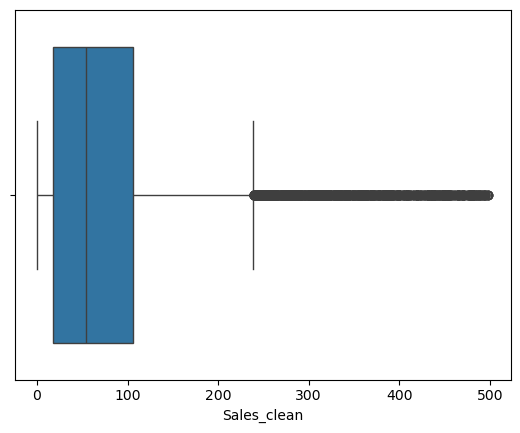

In [21]:
sns.boxplot(data=SaaS_data, x="Sales_clean")
plt.show()

In [22]:
SaaS_data['Sales_clean_log'] = np.log(SaaS_data['Sales_clean'])
print("Dataset with Log Transformed Sales:")
SaaS_data.head(10000)

Dataset with Log Transformed Sales:


,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,...,Product,License,Sales,Quantity,Discount,Profit,outliers_tukey,Sales_mean,Sales_clean,Sales_clean_log
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,...,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136,False,92.864853,261.960000,5.568192
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,...,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820,True,92.864853,92.864853,4.531145
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,...,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714,False,92.864853,14.620000,2.682390
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,...,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310,True,92.864853,92.864853,4.531145
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,...,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164,False,92.864853,22.368000,3.107631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,EMEA-2020-110422,1/22/2020,20200122,Dan Allan,Germany,Hamburg,EMEA,EU-WEST,Johnson & Johnson,...,SaaS Connector Pack,ETHXMB5TMD,25.2480,3,0.20,4.1028,False,92.864853,25.248000,3.228747
9990,9991,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,...,SaaS Connector Pack,LYHOKTRY7L,91.9600,2,0.00,15.6332,False,92.864853,91.960000,4.521354
9991,9992,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,...,Site Analytics,I5SVMI6M88,258.5760,2,0.20,19.3932,False,92.864853,258.576000,5.555190
9992,9993,AMER-2023-121258,2/27/2023,20230227,Anthony Sanderson,United States,Milwaukee,AMER,NAMER,American Express,...,Support,JHLW4P6LQ2,29.6000,4,0.00,13.3200,False,92.864853,29.600000,3.387774


C:\Users\USER\AppData\Local\Temp\ipykernel_31480\881294559.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(SaaS_data['Sales_clean_log'], shade=True, color='red')


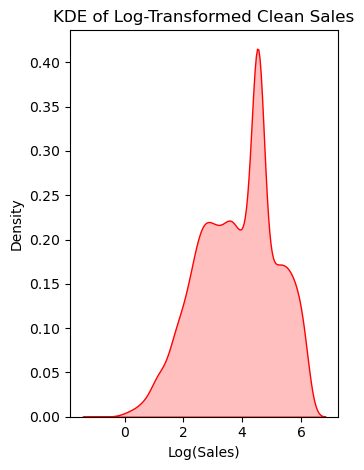

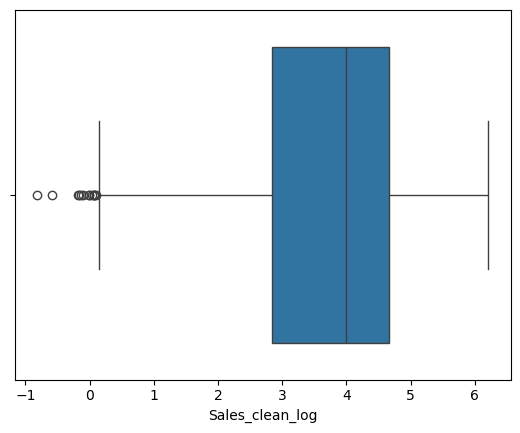

In [23]:
plt.subplot(1, 2, 2)
sns.kdeplot(SaaS_data['Sales_clean_log'], shade=True, color='red')
plt.title('KDE of Log-Transformed Clean Sales')
plt.xlabel('Log(Sales)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()
sns.boxplot(data=SaaS_data, x="Sales_clean_log")
plt.show()

In [ ]:
SaaS_data.to_csv('Clean_SaaS.csv')